In [4]:
notebook_mode = True
viz_mode = False

In [5]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    print("CUDA is available. GPU can be used.")
    print("Number of GPUs available:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. GPU cannot be used.")


CUDA is not available. GPU cannot be used.


# Import packages

In [6]:
import os
import json
import argparse
import time
import random

import numpy as np
import csv

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter  # tensorboardXの代替

import matplotlib
import matplotlib.pyplot as plt

import networkx as nx
from sklearn.utils.class_weight import compute_class_weight

from fastprogress import master_bar, progress_bar

# Remove warning
import warnings
#warnings.filterwarnings("ignore", category=UserWarning)
warnings.simplefilter("ignore")
from scipy.sparse import SparseEfficiencyWarning
warnings.simplefilter('ignore', SparseEfficiencyWarning)

from config import *
from utils.graph_utils import *
from utils.exact_solution import SolveExactSolution
from utils.beamsearch_uelb import *
from utils.flow import Flow
from utils.data_maker import DataMaker
from utils.dataset_reader import DatasetReader
from utils.plot_utils import *
from models.gcn_model import ResidualGatedGCNModel
from utils.model_utils import *

# Setting for notebook

In [7]:
if notebook_mode == True:
    %load_ext autoreload
    %autoreload 2
    %matplotlib inline
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats('png')

# Load configurations

In [8]:
config_path = "configs/default.json"

config = get_config(config_path)
print("Loaded {}:\n{}".format(config_path, config))

Loaded configs/default.json:
{'expt_name': 'deafult', 'gpu_id': '0', 'graph_filepath': './data/graph.gml', 'edge_numbering_filepath': './data/edge_numbering_file.csv', 'train_filepath': './data/gragh.gml', 'val_filepath': './data/tsp10_val_concorde.txt', 'test_filepath': './data/tsp10_test_concorde.txt', 'solver_type': 'pulp', 'graph_model': 'nsfnet', 'num_train_data': 160, 'num_test_data': 20, 'num_val_data': 20, 'num_nodes': 14, 'num_neighbors': 5, 'num_commodities': 10, 'sample_size': 5, 'capacity_lower': 500, 'capacity_higher': 1000, 'demand_lower': 1, 'demand_higher': 500, 'node_dim': 10, 'voc_nodes_in': 2, 'voc_nodes_out': 2, 'voc_edges_in': 3, 'voc_edges_out': 10, 'beam_size': 10, 'hidden_dim': 50, 'num_layers': 3, 'mlp_layers': 2, 'aggregation': 'mean', 'max_epochs': 10, 'val_every': 5, 'test_every': 10, 'batch_size': 20, 'batches_per_epoch': 500, 'accumulation_steps': 1, 'learning_rate': 0.001, 'decay_rate': 1.01}


# Configure GPU options

In [9]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(config.gpu_id) 

if torch.cuda.is_available():
    print("CUDA available, using GPU ID {}".format(config.gpu_id))
    dtypeFloat = torch.cuda.FloatTensor
    dtypeLong = torch.cuda.LongTensor
    torch.cuda.manual_seed(1)
else:
    print("CUDA not available")
    dtypeFloat = torch.float
    dtypeLong = torch.long
    torch.manual_seed(1)

CUDA not available


# Make graph dataset
gragh.gmlとedge_numbering_file.csvの作成

In [182]:
create_data_files(config, data_mode="test")

0  data was created.
10  data was created.


In [91]:
for data in range(20):
    data_mode = "test"
    file_number = data - (data % 10)
    solver_type = config.solver_type
    graph_file_name = "./data/{data_mode}_data/graph_file/{file_number}/graph_{data}.gml".format(data_mode=data_mode, file_number=file_number, data=data)
    comodity_file_name = "./data/{data_mode}_data/commodity_file/{file_number}/commodity_data_{data}.csv".format(data_mode=data_mode, file_number=file_number, data=data)
    
    # 厳密解の計算
    E = SolveExactSolution(solver_type, comodity_file_name, graph_file_name)
    flow_var_kakai, edge_list, objective_value, elapsed_time = E.solve_exact_solution_to_env()
    node_flow_matrix, edge_flow_matrix, infinit_loop = E.generate_flow_matrices(flow_var_kakai)
    print("data: ", data) 
    print("objective_value: ", objective_value)
    

python(16938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  0
objective_value:  0.64646465
data:  1
objective_value:  0.66955267


python(16961) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16962) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  2
objective_value:  0.51051051


python(16963) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  3
objective_value:  0.79717587
data:  4
objective_value:  0.7326284


python(16996) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16997) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  5
objective_value:  0.84347826
data:  6
objective_value:  0.60338346


python(16998) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(16999) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  7
objective_value:  0.66504065
data:  8
objective_value:  0.76308901


python(17000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  9
objective_value:  0.68659128
data:  10
objective_value:  0.76982893


python(17002) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17003) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  11
objective_value:  0.65343915
data:  12
objective_value:  0.72744015


python(17004) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17005) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  13
objective_value:  0.65486726
data:  14
objective_value:  0.69658887


python(17006) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17007) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  15
objective_value:  0.42833333
data:  16
objective_value:  0.72591362


python(17030) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17031) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  17
objective_value:  0.62354892
data:  18
objective_value:  0.80614407


python(17032) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(17033) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


data:  19
objective_value:  0.72035139


# Test data loading

Number of batches of size 20: 1
Batch generation took: 0.066 sec
edges shape: (20, 14, 14)
edges: [[0 1 1 0 0 0 0 1 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 1 1 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 1 0 0 1 0]
 [0 0 0 0 1 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 1 0 1]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 1 0]
 [0 0 0 0 0 1 0 0 0 0 0 1 0 1]
 [0 0 0 0 0 0 0 0 1 0 1 0 1 0]]
edges_capacity shape: (20, 14, 14)
edges_capacity: [[  0. 693. 548.   0.   0.   0.   0. 690.   0.   0.   0.   0.   0.   0.]
 [693.   0. 942. 685.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [548. 942.   0.   0.   0. 882.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 685.   0.   0. 942.   0.   0.   0.   0.   0. 571.   0.   0.   0.]
 [  0.   0.   0. 942.   0. 828. 715.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 882.   0. 828.   0.   0.   0.   0. 961.

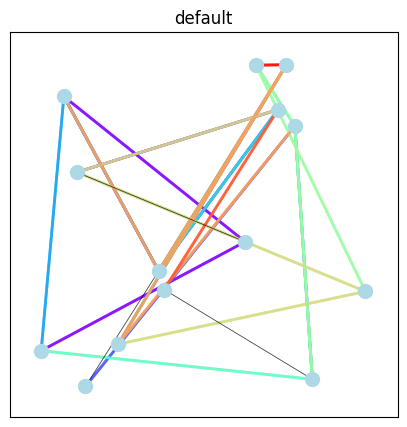

In [101]:
if notebook_mode:
    mode = "test"
    num_data = getattr(config, f'num_{mode}_data')
    batch_size = config.batch_size
    #　DataMakerを繰り返し呼び出しバッチごとにtensorを生成する
    dataset = DatasetReader(num_data, batch_size, mode)
    print("Number of batches of size {}: {}".format(batch_size, dataset.max_iter))

    t = time.time()
    
    idx = 0
    batch = next(iter(dataset))  # Generate a batch of TSPs
    print("Batch generation took: {:.3f} sec".format(time.time() - t))
    print("edges shape:", batch.edges.shape)
    print("edges:", batch.edges[idx])
    print("edges_capacity shape:", batch.edges_capacity.shape)
    print("edges_capacity:", batch.edges_capacity[idx])
    print("edges_targets shape:", batch.edges_target.shape)
    print("edges_targets:", batch.edges_target[idx, :, :, idx])
    print("nodes shape:", batch.nodes.shape)
    print("nodes:", batch.nodes[idx])
    print("nodes_target shape:", batch.nodes_target.shape)
    print("nodes_target:", batch.nodes_target[idx])
    print("commodities shape:", batch.commodities.shape)
    print("commodities:", batch.commodities[idx])
    print("load_factor shape:", batch.load_factor)
    
    f = plt.figure(figsize=(5, 5))
    a = f.add_subplot(111)
    plot_uelb(a, batch.edges[idx], batch.edges_target[idx])

# Instantiate model

In [20]:
if notebook_mode == True:
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
    
    # Define optimizer
    learning_rate = config.learning_rate
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)

    # Enable anomaly detection
    torch.autograd.set_detect_anomaly(True)

DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_commodity_embedding): Linear(in_features=10, out_features=50, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=50, bias=False)
    (gcn_layers): ModuleList(
      (0-2): 3 x ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (relu): ReLU(inplace=True)
      )
    )
    (mlp_edges

# Test forward pass

In [22]:
if notebook_mode == True and viz_mode == False:
    # Generate a batch of UELBs
    mode = "train"
    num_data = getattr(config, f'num_{mode}_data')
    batch_size = config.batch_size
    train_filepath = config.train_filepath
    dataset = iter(DatasetReader(num_data, batch_size, mode))
    batch = next(dataset)

    # Convert batch to torch Variables
    x_edges = torch.LongTensor(batch.edges).to(torch.long).contiguous().requires_grad_(False)
    x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
    x_nodes = torch.FloatTensor(batch.nodes).to(torch.float).contiguous().requires_grad_(False)
    y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
    y_nodes = torch.LongTensor(batch.nodes_target).to(torch.long).contiguous().requires_grad_(False)
    batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)
    
    # Compute class weights
    edge_labels = y_edges.cpu().numpy().flatten()
    edge_cw = create_edge_class_weights(y_edges)
    print("Class weights: {}".format(edge_cw))
        
    # Enable anomaly detection
    torch.autograd.set_detect_anomaly(True)

    # Forward pass
    y_preds, loss = net.forward(x_edges, x_edges_capacity, x_nodes, y_edges, edge_cw)
    loss = loss.mean()
    print("Output size: {}".format(y_preds.size()))
    #print("Output: {}".format(y_preds[0, :, :, 0]))
    print("Loss value:", loss)

Class weights: tensor([ 0.5148, 17.4067])
Output size: torch.Size([20, 14, 14, 10])
Loss value: tensor(6.7539, grad_fn=<MeanBackward0>)


# Test backward pass

In [34]:
if notebook_mode == True and viz_mode == False:
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    
    # Optimizer step
    optimizer.step()
    
    # Compute error metrics 
    err_edges, err_flow, err_uelb, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
    print("Edge error: {:.3f}\nFlow error: {:.3f}\nUELB error: {:.3f}".format(err_edges, err_flow, err_uelb))
    
    # Compute mean predicted and groundtruth tour length
    mean_maximum_load_factor = mean_load_factor(x_edges_capacity, y_preds, x_edges, batch_commodities)
    gt_load_factor = np.mean(batch.load_factor) 
    print("Predicted load factor(Not always a feasible solution): {:.3f}\nGroundtruth load factor: {:.3f}".format(mean_maximum_load_factor, gt_load_factor))

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

# Training Loop (one epoch)

In [33]:
def train_one_epoch(net, optimizer, config, master_bar):
    # Set training mode
    net.train()

    # Assign parameters
    mode = "train"
    num_data = getattr(config, f'num_{mode}_data')
    num_commodities = config.num_commodities
    num_nodes = config.num_nodes
    beam_size = config.beam_size
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    
    # Load UELB data
    dataset = DatasetReader(num_data, batch_size, mode)
    if batches_per_epoch != -1:
        batches_per_epoch = min(batches_per_epoch, dataset.max_iter)
    else:
        batches_per_epoch = dataset.max_iter

    # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    # running_err_edges = 0.0
    # running_err_tour = 0.0
    # running_err_tsp = 0.0
    running_mean_maximum_load_factor = 0.0
    running_gt_load_factor = 0.0
    running_nb_data = 0
    running_nb_batch = 0

    start_epoch = time.time()
    for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
        # Generate a batch of TSPs
        try:
            batch = next(dataset)
        except StopIteration:
            break

        # Convert batch to torch Variables
        x_edges = torch.LongTensor(batch.edges).to(torch.long).contiguous().requires_grad_(False)
        x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
        x_nodes = torch.FloatTensor(batch.nodes).to(torch.float).contiguous().requires_grad_(False)
        y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
        y_nodes = torch.LongTensor(batch.nodes_target).to(torch.long).contiguous().requires_grad_(False)
        batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)
        
        # Compute class weights (if uncomputed)
        if type(edge_cw) != torch.Tensor:
            edge_labels = y_edges.cpu().numpy().flatten()
            edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
        
        # Forward pass
        y_preds, loss = net.forward(x_edges, x_edges_capacity, x_nodes, y_edges, edge_cw)
        """for beamsearch
        beam_search = BeamsearchUELB(
                y_preds, beam_size, batch_size, x_edges_capacity, batch_commodities, dtypeFloat, dtypeLong, strict=False) 
        bs_nodes, pred_paths = beam_search.search()
        """
        loss = loss.mean()  # Take mean of loss across multiple GPUs
        loss = loss / accumulation_steps  # Scale loss by accumulation steps
        loss.backward()

        # Backward pass
        if (batch_num+1) % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        # Compute error metrics and mean load factor
        # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
        #mean_maximum_load_factor = mean_feasible_load_factor(batch_size, num_commodities, num_nodes, pred_paths, x_edges_capacity, batch_commodities)

        
        gt_load_factor = np.mean(batch.load_factor) 

        # Update running data
        running_nb_data += batch_size
        running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
        # running_err_edges += batch_size* err_edges
        # running_err_tour += batch_size* err_tour
        # running_err_tsp += batch_size* err_tsp
        #running_mean_maximum_load_factor += batch_size* mean_maximum_load_factor
        #running_gt_load_factor += batch_size* gt_load_factor
        running_nb_batch += 1
        
        # Log intermediate statistics
        """
        result = ('loss:{loss:.4f} mean_maximum_load_factor:{mean_maximum_load_factor:.3f} gt_load_factor:{gt_load_factor:.3f}'.format(
            loss=running_loss/running_nb_data,
            mean_maximum_load_factor=running_mean_maximum_load_factor/running_nb_data,
            gt_load_factor=running_gt_load_factor/running_nb_data))
        master_bar.child.comment = result
        """
    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    mean_maximum_load_factor = 0 # running_mean_maximum_load_factor/ running_nb_data
    gt_load_factor = 0 # running_gt_load_factor/ running_nb_data

    return time.time()-start_epoch, loss, err_edges, err_tour, err_tsp, mean_maximum_load_factor, gt_load_factor


def metrics_for_train(epoch, time, learning_rate, loss):
    result = ( 'epoch:{epoch:0>2d}\t'
               'time:{time:.2f}h\t'
               'lr:{learning_rate:.2e}\t'
               'loss:{loss:.4f}'.format(
                   epoch=epoch,
                   time=time/3600,
                   learning_rate=learning_rate,
                   loss=loss,
                ))
    return result
    
def metrics_to_str(epoch, time, learning_rate, loss, err_edges, err_tour, err_tsp, mean_maximum_load_factor, gt_load_factor):
    result = ( 'epoch:{epoch:0>2d}\t'
               'time:{time:.1f}s\t'
               'lr:{learning_rate:.2e}\t'
               'loss:{loss:.4f}\t'
               # 'err_edges:{err_edges:.2f}\t'
               # 'err_tour:{err_tour:.2f}\t'
               # 'err_tsp:{err_tsp:.2f}\t'
               'mean_maximum_load_factor:{mean_maximum_load_factor:.3f}\t'
               'gt_load_factor:{gt_load_factor:.3f}'.format(
                   epoch=epoch,
                   time=time/3600,
                   learning_rate=learning_rate,
                   loss=loss,
                   # err_edges=err_edges,
                   # err_tour=err_tour,
                   # err_tsp=err_tsp,
                   mean_maximum_load_factor=mean_maximum_load_factor,
                   gt_load_factor=gt_load_factor))
    return result

In [107]:
if notebook_mode==True and viz_mode==False:
    epoch_bar = master_bar(range(1))
    for epoch in epoch_bar:
        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, mean_maximum_load_factor, gt_load_factor = train_one_epoch(net, optimizer, config, epoch_bar)
        epoch_bar.write('t: ' + metrics_for_train(epoch, train_time, learning_rate, train_loss))

max_iter:  8


# Evaluation Loop (for validation and test sets)

In [58]:
import torch

# サンプルデータ
bs_node = torch.tensor([[
    [ 0,  0,  0,  0,  1,  0,  2,  3,  4,  0,  0,  0,  0,  0],
    [ 4,  5,  0,  0,  0,  0,  0,  3,  2,  0,  0,  0,  0,  1],
    [ 0,  0,  0,  4,  5,  0,  6,  0,  0,  0,  3,  2,  1,  0],
    [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  2,  3],
    [ 0,  0,  0,  0,  3,  2,  0,  0,  0,  1,  0,  0,  0,  0],
    [ 8,  6,  7,  5,  4,  3,  0,  9,  1,  2,  0,  0,  0,  0],
    [ 4,  0,  3,  0,  0,  2,  0,  0,  0,  1,  0,  0,  0,  0],
    [ 0,  0,  0,  1,  0,  0,  0,  0,  4,  0,  2,  3,  0,  0],
    [ 0,  1,  2,  0,  0,  3,  0,  0,  0,  4,  0,  0,  0,  0],
    [ 0,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]
]])
# サンプルデータ
#pred_paths = [[[4, 6, 7, 8], [13, 8, 9, 5, 4, 6, 7, 0, 2, 1], [12, 13, 8, 7, 6], [5, 4, 6, 7, 0, 2, 1, 3, 10, 11, 8, 13], [9, 5, 4], [8, 13, 10, 3, 1, 2, 5, 4, 6, 7], [9, 8, 13, 10, 3, 1, 2, 5, 4, 6, 7, 0], [3, 10, 11, 8], [1, 3, 4, 6, 7, 0, 2, 5, 12, 11, 10, 13, 8, 9], [3, 1]]]
pred_paths = [[[4, 5, 9, 8], [13, 10, 3, 1], [12, 5, 4, 6], [5, 12, 11, 8, 13], [9, 5, 2, 1, 3, 4], [8, 7], [9, 5, 2, 0], [3, 10, 13, 8], [1, 2, 5, 9], [3, 1]]]
# 厳密解のフロー
bs_node = torch.tensor([[
    [0, 0, 0, 0, 1, 2, 0, 0, 4, 3, 0, 0, 0, 0],
    [0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1],
    [0, 0, 0, 0, 3, 2, 4, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1, 0, 0, 4, 0, 0, 3, 2, 5],
    [0, 4, 3, 5, 6, 2, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0],
    [4, 0, 3, 0, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 2, 0, 0, 3],
    [0, 1, 2, 0, 0, 3, 0, 0, 0, 4, 0, 0, 0, 0],
    [0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
]])

commodities = torch.tensor([[
    [4, 8, 452],
    [13, 1, 424],
    [12, 6, 404],
    [5, 13, 357],
    [9, 4, 348],
    [8, 7, 201],
    [9, 0, 185],
    [3, 8, 156],
    [1, 9, 31],
    [3, 1, 1]
    ]])
num_batch = 1
num_flow = 10
num_node = 14

edges_capacity = torch.tensor([[
    [0., 737., 713., 0., 0., 0., 0., 789., 0., 0., 0., 0., 0., 0.],
    [737., 0., 801., 915., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [713., 801., 0., 0., 0., 924., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 915., 0., 0., 560., 0., 0., 0., 0., 0., 766., 0., 0., 0.],
    [0., 0., 0., 560., 0., 993., 963., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 924., 0., 993., 0., 0., 0., 0., 840., 0., 0., 742., 0.],
    [0., 0., 0., 0., 963., 0., 0., 801., 0., 0., 0., 0., 0., 0.],
    [789., 0., 0., 0., 0., 0., 801., 0., 575., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 575., 0., 693., 0., 630., 0., 604.],
    [0., 0., 0., 0., 0., 840., 0., 0., 693., 0., 0., 0., 0., 0.],
    [0., 0., 0., 766., 0., 0., 0., 0., 0., 0., 0., 511., 0., 913.],
    [0., 0., 0., 0., 0., 0., 0., 0., 630., 0., 511., 0., 629., 0.],
    [0., 0., 0., 0., 0., 742., 0., 0., 0., 0., 0., 629., 0., 500.],
    [0., 0., 0., 0., 0., 0., 0., 0., 604., 0., 913., 0., 500., 0.]
]])
# テスト用に関数を呼び出し
mean_max_load_factor = mean_feasible_load_factor(num_batch, num_flow, num_node, pred_paths, edges_capacity, commodities)
print("Mean Feasible Load Factor:", mean_max_load_factor)

bs_edges_summed:  tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,  31, 348,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [185, 348,   0,   0,   0,  31,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0, 425,   0,   0, 348,   0,   0,   0,   0,   0, 156,   0,   0,   0],
        [  0,   0,   0,   0,   0, 452, 404,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0, 533,   0, 404,   0,   0,   0,   0, 483,   0,   0, 357,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0, 201,   0,   0,   0,   0,   0, 357],
        [  0,   0,   0,   0,   0, 533,   0,   0, 452,   0,   0,   0,   0,   0],
        [  0,   0,   0, 424,   0,   0,   0,   0,   0,   0,   0,   0,   0, 156],
        [  0,   0,   0,   0,   0,   0,   0,   0, 357,   0,   0,   0,   0,   0],
        [  0,   0,   0

# ビームサーチ＆エッジの教師データの有効性検証

In [98]:
def beam_test(net, config, master_bar, mode='train'):
    # Set evaluation mode
    net.eval()
    
    # Assign parameters
    num_data = getattr(config, f'num_{mode}_data')
    #batch_size = config.batch_size
    #num_data = 1
    batch_size = 1
    num_commodities = config.num_commodities
    num_nodes = config.num_nodes
    beam_size = config.beam_size
    #batches_per_epoch = config.batches_per_epoch
    batches_per_epoch = 1
    accumulation_steps = config.accumulation_steps
    
    # Load UELB data
    dataset = DatasetReader(num_data, batch_size, mode)
    
        # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_mean_maximum_load_factor = 0.0
    running_gt_load_factor = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            print("batch_num: ", batch_num)
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
            y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
            batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)     

            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
                

            beam_search = BeamsearchUELB(
                y_edges, beam_size, batch_size, x_edges_capacity, batch_commodities, dtypeFloat, dtypeLong, mode_strict=True) 
            #bs_nodes, pred_paths = beam_search.search()
            pred_paths = beam_search.search()
            torch.set_printoptions(linewidth=200)
            for i in range(10):
                print(f"y_edges[0, :, :, {i}]:\n", y_edges[0, :, :, 0])
            print("pred_paths:\n", pred_paths)
            
            #if batch_num == 0:
                #print("bs_nodes.shape: ", bs_nodes.shape)
                #print("bs_nodes:\n", bs_nodes)
                #print("pred_paths:\n", pred_paths)
            
            # Compute error metrics and mean load factor
            # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
            mean_maximum_load_factor = mean_feasible_load_factor(batch_size, num_commodities, num_nodes, pred_paths, x_edges_capacity, batch_commodities)
            print("mean_maximum_load_factor: ", mean_maximum_load_factor)
            gt_load_factor = np.mean(batch.load_factor)
            print("gt_load_factor: ", gt_load_factor)
            #if mean_maximum_load_factor < gt_load_factor:
               #print("x_edges_capacity:\n", x_edges_capacity)
                #print("batch_commodities:\n", batch_commodities)
                #print("pred_paths:\n", pred_paths)
        
            
    # Compute statistics for full epoch


    return mean_maximum_load_factor, gt_load_factor

In [99]:
val_pred_tour_len, val_gt_tour_len = beam_test(net, config, epoch_bar, mode='test')

batch_num:  0
y_edges[0, :, :, 0]:
 tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
y_edges[0, :, :, 1]:
 tensor([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
     

In [60]:
def test(net, config, master_bar, mode='test'):
    # Set evaluation mode
    net.eval()
    
    # Assign parameters
    num_data = getattr(config, f'num_{mode}_data')
    batch_size = config.batch_size
    #num_data = 1
    #batch_size = 1
    num_commodities = config.num_commodities
    num_nodes = config.num_nodes
    beam_size = config.beam_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    
    # Load UELB data
    dataset = DatasetReader(num_data, batch_size, mode)
    
        # Convert dataset to iterable
    dataset = iter(dataset)
    
    # Initially set loss class weights as None
    edge_cw = None

    # Initialize running data
    running_loss = 0.0
    running_mean_maximum_load_factor = 0.0
    running_gt_load_factor = 0.0
    running_nb_data = 0
    running_nb_batch = 0
    
    with torch.no_grad():
        start_test = time.time()
        for batch_num in progress_bar(range(batches_per_epoch), parent=master_bar):
            # Generate a batch of TSPs
            try:
                batch = next(dataset)
            except StopIteration:
                break

            # Convert batch to torch Variables
            x_edges = torch.LongTensor(batch.edges).to(torch.long).contiguous().requires_grad_(False)
            x_edges_capacity = torch.FloatTensor(batch.edges_capacity).to(torch.float).contiguous().requires_grad_(False)
            x_nodes = torch.FloatTensor(batch.nodes).to(torch.float).contiguous().requires_grad_(False)
            y_edges = torch.LongTensor(batch.edges_target).to(torch.long).contiguous().requires_grad_(False)
            y_nodes = torch.LongTensor(batch.nodes_target).to(torch.long).contiguous().requires_grad_(False)
            batch_commodities = torch.LongTensor(batch.commodities).to(torch.long).contiguous().requires_grad_(False)     

            # Compute class weights (if uncomputed)
            if type(edge_cw) != torch.Tensor:
                edge_labels = y_edges.cpu().numpy().flatten()
                edge_cw = compute_class_weight("balanced", classes=np.unique(edge_labels), y=edge_labels)
                

            # Forward pass
            y_preds, loss = net.forward(x_edges, x_edges_capacity, x_nodes, y_edges, edge_cw)
            loss = loss.mean()  # Take mean of loss across multiple GPUs    
            beam_search = BeamsearchUELB(
                y_preds, beam_size, batch_size, x_edges_capacity, batch_commodities, dtypeFloat, dtypeLong, mode_strict=True) 
            #bs_nodes, pred_paths = beam_search.search()
            pred_paths = beam_search.search()
            
            #if batch_num == 0:
                #print("bs_nodes.shape: ", bs_nodes.shape)
                #print("bs_nodes:\n", bs_nodes)
                #print("pred_paths:\n", pred_paths)
            
            # Compute error metrics and mean load factor
            # err_edges, err_tour, err_tsp, tour_err_idx, tsp_err_idx = edge_error(y_preds, y_edges, x_edges)
            mean_maximum_load_factor = mean_feasible_load_factor(batch_size, num_commodities, num_nodes, pred_paths, x_edges_capacity, batch_commodities)
            print("mean_maximum_load_factor: ", mean_maximum_load_factor)
            gt_load_factor = np.mean(batch.load_factor) 

            # Update running data
            running_nb_data += batch_size
            running_loss += batch_size* loss.data.item()* accumulation_steps  # Re-scale loss
            running_mean_maximum_load_factor += batch_size* mean_maximum_load_factor
            running_gt_load_factor += batch_size* gt_load_factor
            running_nb_batch += 1
        
            # Log intermediate statistics
            result = ('loss:{loss:.4f} mean_maximum_load_factor:{mean_maximum_load_factor:.3f} gt_load_factor:{gt_load_factor:.3f}'.format(
                loss=running_loss/running_nb_data,
                mean_maximum_load_factor=running_mean_maximum_load_factor/running_nb_data,
                gt_load_factor=running_gt_load_factor/running_nb_data))
            master_bar.child.comment = result
            
    # Compute statistics for full epoch
    loss = running_loss/ running_nb_data
    err_edges = 0 # running_err_edges/ running_nb_data
    err_tour = 0 # running_err_tour/ running_nb_data
    err_tsp = 0 # running_err_tsp/ running_nb_data
    mean_maximum_load_factor = running_mean_maximum_load_factor/ running_nb_data
    gt_load_factor = running_gt_load_factor/ running_nb_data

    return time.time()-start_test, loss, err_edges, err_tour, err_tsp, mean_maximum_load_factor, gt_load_factor


In [54]:
if notebook_mode==True and viz_mode==False:
    epoch_bar = master_bar(range(1))
    for epoch in epoch_bar:
        # Validation
        val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
        epoch_bar.write('v: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
        # Testing
        test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
        epoch_bar.write('T: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len))

demand:  404
best_path:  [12, 13, 8, 7, 6]
remaining_edges_capacity:  tensor([[  0., 737., 713.,   0.,   0.,   0.,   0., 789.,   0.,   0.,   0.,   0.,   0.,   0.],
        [737.,   0., 801., 915.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [713., 801.,   0.,   0.,   0., 924.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 915.,   0.,   0., 560.,   0.,   0.,   0.,   0.,   0., 766.,   0.,   0.,   0.],
        [  0.,   0.,   0., 560.,   0., 993., 963.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 924.,   0., 993.,   0.,   0.,   0.,   0., 840.,   0.,   0., 742.,   0.],
        [  0.,   0.,   0.,   0., 963.,   0.,   0., 801.,   0.,   0.,   0.,   0.,   0.,   0.],
        [789.,   0.,   0.,   0.,   0.,   0., 397.,   0., 575.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0., 171.,   0., 693.,   0., 630.,   0., 604.],
        [  0.,   0.,   0.,   0.,   0., 840.,   0.,   0., 693.,   0.,   0.,   0.,   0

In [ ]:
edges_capacity = torch.tensor([[
    [0., 737., 713., 0., 0., 0., 0., 789., 0., 0., 0., 0., 0., 0.],
    [737., 0., 801., 915., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    [713., 801., 0., 0., 0., 924., 0., 0., 0., 0., 0., 0., 0., 0.],
    [0., 915., 0., 0., 560., 0., 0., 0., 0., 0., 766., 0., 0., 0.],
    [0., 0., 0., 560., 0., 993., 963., 0., 0., 0., 0., 0., 0., 0.],
    [0., 0., 924., 0., 993., 0., 0., 0., 0., 840., 0., 0., 742., 0.],
    [0., 0., 0., 0., 963., 0., 0., 801., 0., 0., 0., 0., 0., 0.],
    [789., 0., 0., 0., 0., 0., 801., 0., 575., 0., 0., 0., 0., 0.],
    [0., 0., 0., 0., 0., 0., 0., 575., 0., 693., 0., 630., 0., 604.],
    [0., 0., 0., 0., 0., 840., 0., 0., 693., 0., 0., 0., 0., 0.],
    [0., 0., 0., 766., 0., 0., 0., 0., 0., 0., 0., 511., 0., 913.],
    [0., 0., 0., 0., 0., 0., 0., 0., 630., 0., 511., 0., 629., 0.],
    [0., 0., 0., 0., 0., 742., 0., 0., 0., 0., 0., 629., 0., 500.],
    [0., 0., 0., 0., 0., 0., 0., 0., 604., 0., 913., 0., 500., 0.]
]])

# Run full training pipeline 

In [61]:
def main(config):
    # Instantiate the network
    net = nn.DataParallel(ResidualGatedGCNModel(config, dtypeFloat, dtypeLong))
    if torch.cuda.is_available():
        net.cuda()
    print(net)

    # Compute number of network parameters
    nb_param = 0
    for param in net.parameters():
        nb_param += np.prod(list(param.data.size()))
    print('Number of parameters:', nb_param)
 
    # Create log directory
    log_dir = f"./logs/{config.expt_name}/"
    os.makedirs(log_dir, exist_ok=True)
    json.dump(config, open(f"{log_dir}/config.json", "w"), indent=4)
    writer = SummaryWriter(log_dir)  # Define Tensorboard writer
    
    # Training parameters
    #num_nodes = config.num_nodes
    #num_neighbors = config.num_neighbors
    max_epochs = config.max_epochs
    val_every = config.val_every
    test_every = config.test_every
    batch_size = config.batch_size
    batches_per_epoch = config.batches_per_epoch
    accumulation_steps = config.accumulation_steps
    learning_rate = config.learning_rate
    decay_rate = config.decay_rate
    val_loss_old = 1e6  # For decaying LR based on validation loss
    best_pred_tour_len = 1e6  # For saving checkpoints
    
    # Define optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    print(optimizer)
    
    epoch_bar = master_bar(range(max_epochs))
    loss_transition = []
    load_factor_transition = []
    for epoch in epoch_bar:
        # Log to Tensorboard
        writer.add_scalar('learning_rate', learning_rate, epoch)
        
        # Train
        train_time, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_mean_maximum_load_factor, train_gt_load_factor = train_one_epoch(net, optimizer, config, epoch_bar)
        #epoch_bar.write('train: ' + metrics_to_str(epoch, train_time, learning_rate, train_loss, train_err_edges, train_err_tour, train_err_tsp, train_mean_maximum_load_factor, train_gt_load_factor))
        epoch_bar.write('train: ' + metrics_for_train(epoch, train_time, learning_rate, train_loss))
        #writer.add_scalar('loss/train_loss', train_loss, epoch)
        #writer.add_scalar('pred_tour_len/train_mean_maximum_load_factor', train_mean_maximum_load_factor, epoch)
        #writer.add_scalar('optimality_gap/train_opt_gap', train_mean_maximum_load_factor/train_gt_load_factor - 1, epoch)
        
        if epoch % val_every == 0 or epoch == max_epochs-1:
            # Validate
            val_time, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len = test(net, config, epoch_bar, mode='val')
            epoch_bar.write('val: ' + metrics_to_str(epoch, val_time, learning_rate, val_loss, val_err_edges, val_err_tour, val_err_tsp, val_pred_tour_len, val_gt_tour_len))
            writer.add_scalar('loss/val_loss', val_loss, epoch)
            writer.add_scalar('pred_tour_len/val_pred_tour_len', val_pred_tour_len, epoch)
            writer.add_scalar('optimality_gap/val_opt_gap', val_pred_tour_len/val_gt_tour_len - 1, epoch)
            
            # Save checkpoint
            if val_pred_tour_len < best_pred_tour_len:
                best_pred_tour_len = val_pred_tour_len  # Update best prediction
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                }, log_dir+"best_val_checkpoint.tar")
            
            # Update learning rate
            if val_loss > 0.99 * val_loss_old:
                learning_rate /= decay_rate
                optimizer = update_learning_rate(optimizer, learning_rate)
            
            val_loss_old = val_loss  # Update old validation loss
        
        if epoch % test_every == 0 or epoch == max_epochs-1:

            # Test
            test_time, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len = test(net, config, epoch_bar, mode='test')
            epoch_bar.write('test: ' + metrics_to_str(epoch, test_time, learning_rate, test_loss, test_err_edges, test_err_tour, test_err_tsp, test_pred_tour_len, test_gt_tour_len))
            writer.add_scalar('loss/test_loss', test_loss, epoch)
            writer.add_scalar('pred_tour_len/test_pred_tour_len', test_pred_tour_len, epoch)
            writer.add_scalar('optimality_gap/test_opt_gap', test_pred_tour_len/test_gt_tour_len - 1, epoch)
            
        # Save training checkpoint at the end of epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, log_dir+"last_train_checkpoint.tar")
        
        # Save checkpoint after every 250 epochs
        if epoch != 0 and (epoch % 250 == 0 or epoch == max_epochs-1):
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, log_dir+f"checkpoint_epoch{epoch}.tar")
            
    return net

In [62]:
if viz_mode==False:
    # del net
    net = main(config)

DataParallel(
  (module): ResidualGatedGCNModel(
    (nodes_commodity_embedding): Linear(in_features=10, out_features=50, bias=False)
    (edges_values_embedding): Linear(in_features=1, out_features=50, bias=False)
    (gcn_layers): ModuleList(
      (0-2): 3 x ResidualGatedGCNLayer(
        (node_feat): NodeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (edge_feat): EdgeFeatures(
          (U): Linear(in_features=50, out_features=50, bias=True)
          (V): Linear(in_features=50, out_features=50, bias=True)
        )
        (bn_node): BatchNormNode(
          (batch_norm): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (bn_edge): BatchNormEdge(
          (batch_norm): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        )
        (relu): ReLU(inplace=True)
      )
    )
    (mlp_edges

mean_maximum_load_factor:  tensor(0.9069)
mean_maximum_load_factor:  tensor(0.9270)
mean_maximum_load_factor:  tensor(0.8699)
mean_maximum_load_factor:  tensor(0.7988)
mean_maximum_load_factor:  tensor(0.8868)
